# Genetic algorithm: Sudoku

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import csv

In [2]:
rng = default_rng(6502729091)

## Genotype definition

Object consisting on:
* Two-dimensional array of 9 x 9 integers, the solution.
* Two-dimensional array of 9 x 9 bools, whether the value on that position is fixed or not.


In [3]:
def ObjectiveFunction(genotype):
    '''Returns the number of repeated values in rows, 
       columns and inner squares
    '''
    N = len(genotype)
    sqrtN = int(N ** 0.5)
    ans = 0
    
    # columns
    for i in range(N):
        ans += N - len(np.unique(genotype[:,i]))
    
    # inner squares
    for i in range(sqrtN):
        for j in range(sqrtN):
            ans += N - len(np.unique(genotype[i * sqrtN : (i + 1) * sqrtN, j * sqrtN : (j + 1) * sqrtN]))
        
    return ans

In [4]:
def SolutionPermutation(initialState):
    '''Fills the given sudoku with random values, respecting
       the given constraints (fixed values)
    '''
    solution = []
    for row in initialState:
        perm = rng.permutation(len(initialState)) + 1
        for i,x in enumerate(row):
            if x != 0:
                perm[np.where(perm == x)[0]] = perm[i]
                perm[i] = x
        solution.append(perm)
    return np.array(solution)

In [6]:
def ReadFromCSV(path):
    ans = np.zeros((9,9), dtype=int)
    with open(path) as f:
        csvf = csv.reader(f, delimiter=',')
        for i, r in enumerate(csvf):
            ans[i] = r
    
    return ans

In [7]:
def FillObvious(genotype):
    '''Goes through the given solution and fills the values
       where there is no other choice
    '''
    board = genotype.copy()
    possible = np.array([[{1,2,3,4,5,6,7,8,9} for i in range(9)] for i in range(9)])
    
    def DiscardRow(r, x):
        for s in possible[r]:
            s.discard(x)
    def DiscardColumn(c, x):
        for s in possible[:,c]:
            s.discard(x)
    def DiscardInnerSquare(n, m, x):
        for r in possible[n * 3:(n + 1) * 3, m * 3:(m + 1) * 3]:
            for s in r:
                s.discard(x)
    
    for i in range(9):
        for j in range(9):
            if board[i,j] != 0:
                DiscardRow(i, board[i,j])
                DiscardColumn(j, board[i,j])
                DiscardInnerSquare(i // 3, j // 3, board[i,j])
    
    changed = 0
    for i in range(9):
        for j in range(9):
            if len(possible[i,j]) == 1 and board[i,j] == 0:
                board[i,j] = list(possible[i,j])[0]
                changed += 1
    
    print(f'Filled {changed} obvious values')
    return board

## Genetic Algorithm

In [8]:
def ParentSelectionRoulette(fitness):
    '''
        Input:  fitness -> Array of pop_size elements
        Output: Index of selected parent
    '''
    total = np.sum(fitness)
    roulette = np.cumsum(fitness / total)
    
    i = 0
    dart = rng.uniform()
    while roulette[i] < dart:
        i += 1
    return i

In [9]:
def ParentSelectionTournament(fitness, k=2):
    '''
        Input:  fitness -> Array of pop_size elements
                k -> size of tournament
        Output: Index of selected parent
    '''
    selection = rng.permutation(len(fitness))
    not_selection = selection[k:]
    raffle = fitness.copy()
    raffle[not_selection] = np.max(raffle) + 1
    return np.argmin(raffle)

In [12]:
def CrossoverSimplePermutation(parent1, parent2):
    '''Applies the simple permutation for all the rows of
       the given sudoku. All rows use the same crossover
       point.
    '''
    final_offspring = np.zeros(parent1.shape, dtype=int)
    cut = rng.integers(low=0, high=len(parent1))
    cnt = 0
    for row1, row2 in zip(parent1, parent2): 
        offspring = np.append(row1[:cut], row2[cut:])
        used = np.zeros(len(row1), dtype=int)
        for x in offspring:
            used[x - 1] += 1
        unused = []
        for i,x in enumerate(used):
            if x == 0:
                unused.append(i + 1)
        unused = rng.permutation(unused)

        for i,x in enumerate(offspring):
            if used[x - 1] > 1:
                used[x - 1] -= 1
                offspring[i] = unused[-1]
                unused = unused[:-1]

        final_offspring[cnt] = offspring
        cnt += 1
        
    return final_offspring

In [48]:
def CrossoverPartiallyMapped(parent1, parent2):
    final_offspring = []
    cut1 = rng.integers(low=0, high=len(parent1))
    cut2 = rng.integers(low=cut1, high=len(parent1))
    for row1, row2 in zip(parent1, parent2):        
        offspring = np.append(row2[:cut1], row1[cut1:cut2])
        offspring = np.append(offspring, row2[cut2:])

        used = np.zeros(len(row1), dtype=int)
        for x in offspring:
            used[x - 1] += 1
        unused = []
        for x in row2[cut1:cut2]:
            if used[x - 1] == 0:
                unused.append(x)
        unused = unused[::-1]

        for i,x in enumerate(offspring[:cut1]):
            if used[x - 1] > 1:
                used[x - 1] -= 1
                offspring[i] = unused[-1]
                unused = unused[:-1]

        for i,x in enumerate(offspring[cut2:]):
            if used[x - 1] > 1:
                used[x - 1] -= 1
                offspring[i + cut2] = unused[-1]
                unused = unused[:-1]

        final_offspring.append(offspring)
        
    return np.array(final_offspring)

In [13]:
def MutationSwap(genotype, initialState):
    '''Randomly selects a row and swaps two non-fixed values
    '''
    r_idx, cnt_not_fixed = None, None
    while True:
        r_idx = rng.integers(low=0, high=9)
        cnt_not_fixed = np.count_nonzero(initialState[r_idx] == 0)
        if cnt_not_fixed >= 2:
            break
    g = rng.integers(low=0, high=cnt_not_fixed, size=2)
    
    c_idx1 = 0
    for i,x in enumerate(initialState[r_idx]): 
        if g[0] == 0 and x == 0:
            c_idx1 = i
            break
        if x == 0:
            g[0] -= 1
    
    c_idx2 = 0
    for i,x in enumerate(initialState[r_idx]): 
        if g[1] == 0 and x == 0:
            c_idx2 = i
            break
        if x == 0:
            g[1] -= 1
    
    genotype[r_idx,c_idx1], genotype[r_idx,c_idx2] = genotype[r_idx,c_idx2], genotype[r_idx,c_idx1]
    return genotype

In [14]:
def SudokuCrossover(population, fitness, Pr):
    new_population = np.zeros(population.shape, dtype=int)
    for i in range(len(population)): 
        if(rng.random() < Pr):
            parent1 = population[ParentSelectionTournament(fitness)]
            parent2 = population[ParentSelectionTournament(fitness)]
            new_population[i] = CrossoverSimplePermutation(parent1, parent2)
        else:
            new_population[i] = population[ParentSelectionTournament(fitness)]
    
    return new_population

In [15]:
def SudokuMutation(population, initialMutation, Pm):
    new_population = np.zeros(population.shape, dtype=int)
    for i, genotype in enumerate(population):
        new_population[i] = MutationSwap(genotype, initialMutation) if rng.random() < Pm else genotype
    return new_population

In [23]:
def SudokuGeneticAlgorithm(initialState, N=30, G=100, Pr=0.8, Pm=0.3):
    population = np.array([SolutionPermutation(initialState) for i in range(N)])
    fitness = np.array([ObjectiveFunction(genotype) for genotype in population])
    elite = population[np.argmin(fitness)].copy()
    elite_fx = np.min(fitness)
    
    current_g = 0
    while current_g < G and elite_fx != 0:
        if current_g % 100 == 0:
            print(f'Generation #{current_g}: fitness = {elite_fx}')
            print(f'min = {np.min(fitness)}, max = {np.max(fitness)}, mean = {np.mean(fitness)}, std = {np.std(fitness)}')
        population = SudokuCrossover(population, fitness, Pr)
        population = SudokuMutation(population, initialState, Pm)
        fitness = np.array([ObjectiveFunction(genotype) for genotype in population])
        if(np.min(fitness) > elite_fx):
            max_idx = ParentSelectionTournament(fitness * -1)
            population[max_idx] = elite
            fitness[max_idx] = elite_fx
        else:
            elite = population[np.argmin(fitness)].copy()
            elite_fx = np.min(fitness)
            
        current_g += 1
    
    return elite, elite_fx, current_g

## Solver

The parameters for the Genetic Algorithm were chosen after experimentation. We noticed that this problem has a lot of local optimas, so we had to be careful not to converge on one of these right away. In terms of Genetic Algorithms, we have to ensure diversity within the population. We bumped the population size to 100 and increased the mutation probability to 0.45 to achieve that.

In [33]:
def SolveSudokuFromCSV(path):
    initialState = ReadFromCSV(path)
    plotInitialState = initialState.copy()
    initialState = FillObvious(initialState)
    elite, elite_fx, total_g = SudokuGeneticAlgorithm(initialState, N=100, G=100000, Pm=0.45, Pr=0.8)
    nrows, ncols = len(elite), len(elite)
    image = np.zeros(nrows*ncols)
    
    print(f'### Total # of generations = {total_g}, fitness = {elite_fx} ###')

    def highlight_cell(x,y, ax=None, **kwargs):
        rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
        ax = ax or plt.gca()
        ax.add_patch(rect)
        return rect

    def highlight_separator(x, y, **kwargs):
        wx, wy = 0, 10
        if x == 0:
            wx, wy = wy, wx
        rect = plt.Rectangle((x-.5, y-0.5), wx, wy, fill=False, **kwargs)
        ax = plt.gca()
        ax.add_patch(rect)
        return rect

    image = image.reshape((nrows, ncols))

    plt.matshow(image, cmap='afmhot')
    for i in range(nrows):
        for j in range(ncols):
            highlight_cell(i, j, color='white', linewidth=2)
    highlight_separator(3, 0, color='white', linewidth=6)
    highlight_separator(6, 0, color='white', linewidth=6)
    highlight_separator(0, 3, color='white', linewidth=6)
    highlight_separator(0, 6, color='white', linewidth=6)

    for i, r in enumerate(elite):
        for j, x in enumerate(r):
            color = 'pink' if plotInitialState[i,j] == 0 else 'white'
            plt.text(j, i, x, color=color, horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold')

    plt.show()

Filled 11 obvious values
Generation #0: fitness = 20
min = 20, max = 41, mean = 32.85, std = 3.715844453149243
### Total # of generations = 28, fitness = 0 ###


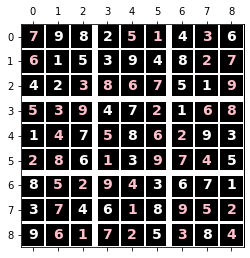

In [34]:
SolveSudokuFromCSV('easy2.csv')

Filled 4 obvious values
Generation #0: fitness = 35
min = 35, max = 59, mean = 44.96, std = 4.293995808102286
Generation #100: fitness = 11
min = 11, max = 19, mean = 12.62, std = 1.9171854370404546
Generation #200: fitness = 8
min = 8, max = 16, mean = 9.52, std = 1.8893385085791272
Generation #300: fitness = 4
min = 4, max = 12, mean = 5.55, std = 2.0754517580517255
Generation #400: fitness = 4
min = 4, max = 12, mean = 6.28, std = 2.2542404485768595
Generation #500: fitness = 4
min = 4, max = 12, mean = 6.22, std = 2.1935359582190577
Generation #600: fitness = 4
min = 4, max = 12, mean = 6.21, std = 2.3207541877587983
Generation #700: fitness = 4
min = 4, max = 12, mean = 5.84, std = 2.062619693496598
Generation #800: fitness = 4
min = 4, max = 14, mean = 6.4, std = 2.3409399821439254
Generation #900: fitness = 4
min = 4, max = 12, mean = 5.51, std = 2.114213801865838
Generation #1000: fitness = 2
min = 2, max = 10, mean = 4.03, std = 2.0467290978534507
### Total # of generations = 

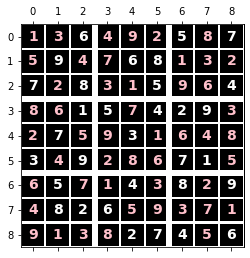

In [35]:
SolveSudokuFromCSV('example1.csv')

In [36]:
SolveSudokuFromCSV('hard1.csv')

Filled 4 obvious values
Generation #0: fitness = 32
min = 32, max = 53, mean = 43.04, std = 4.791492460601394
Generation #100: fitness = 8
min = 8, max = 16, mean = 9.54, std = 2.026918843959965
Generation #200: fitness = 8
min = 8, max = 16, mean = 9.51, std = 1.824801359052541
Generation #300: fitness = 8
min = 8, max = 16, mean = 9.46, std = 1.961733926912618
Generation #400: fitness = 8
min = 8, max = 13, mean = 9.07, std = 1.5248278591368927
Generation #500: fitness = 8
min = 8, max = 16, mean = 10.07, std = 2.117805467931368
Generation #600: fitness = 8
min = 8, max = 17, mean = 9.8, std = 1.96468827043885
Generation #700: fitness = 8
min = 8, max = 15, mean = 9.76, std = 1.8821264569629748
Generation #800: fitness = 8
min = 8, max = 15, mean = 9.39, std = 1.7256592942988485
Generation #900: fitness = 6
min = 6, max = 14, mean = 7.28, std = 1.8225257199831226
Generation #1000: fitness = 6
min = 6, max = 14, mean = 7.43, std = 1.8934360300786501
Generation #1100: fitness = 6
min =

Generation #9500: fitness = 2
min = 2, max = 12, mean = 3.69, std = 2.18949765928169
Generation #9600: fitness = 2
min = 2, max = 10, mean = 3.56, std = 1.9915822855207364
Generation #9700: fitness = 2
min = 2, max = 8, mean = 3.61, std = 1.8595429545993287
Generation #9800: fitness = 2
min = 2, max = 12, mean = 3.92, std = 2.225668438918969
Generation #9900: fitness = 2
min = 2, max = 9, mean = 4.09, std = 2.049853653312841
Generation #10000: fitness = 2
min = 2, max = 9, mean = 3.8, std = 2.0199009876724157
Generation #10100: fitness = 2
min = 2, max = 11, mean = 4.21, std = 2.259623862504554
Generation #10200: fitness = 2
min = 2, max = 9, mean = 3.91, std = 1.924032224262369
Generation #10300: fitness = 2
min = 2, max = 10, mean = 3.92, std = 2.1664717861075413
Generation #10400: fitness = 2
min = 2, max = 10, mean = 4.41, std = 2.271981514009302
Generation #10500: fitness = 2
min = 2, max = 12, mean = 3.9, std = 2.2516660498395407
Generation #10600: fitness = 2
min = 2, max = 10, 

Generation #19000: fitness = 2
min = 2, max = 8, mean = 4.03, std = 1.9102617621676878
Generation #19100: fitness = 2
min = 2, max = 9, mean = 4.15, std = 1.909842925478428
Generation #19200: fitness = 2
min = 2, max = 10, mean = 4.0, std = 1.8973665961010275
Generation #19300: fitness = 2
min = 2, max = 10, mean = 3.74, std = 2.066978471102203
Generation #19400: fitness = 2
min = 2, max = 10, mean = 4.35, std = 2.471335671251479
Generation #19500: fitness = 2
min = 2, max = 10, mean = 3.86, std = 2.0737405816543206
Generation #19600: fitness = 2
min = 2, max = 10, mean = 3.85, std = 2.0414455662593602
Generation #19700: fitness = 2
min = 2, max = 11, mean = 3.73, std = 1.9741073932286461
Generation #19800: fitness = 2
min = 2, max = 10, mean = 4.07, std = 2.446446402437626
Generation #19900: fitness = 2
min = 2, max = 11, mean = 3.81, std = 2.2076911015810157
Generation #20000: fitness = 2
min = 2, max = 12, mean = 3.88, std = 2.098952119511067
Generation #20100: fitness = 2
min = 2, 

Generation #28500: fitness = 2
min = 2, max = 10, mean = 4.13, std = 2.110236953519675
Generation #28600: fitness = 2
min = 2, max = 9, mean = 3.74, std = 1.9006314740106771
Generation #28700: fitness = 2
min = 2, max = 12, mean = 4.13, std = 2.411037121240567
Generation #28800: fitness = 2
min = 2, max = 10, mean = 4.21, std = 2.0312311537587244
Generation #28900: fitness = 2
min = 2, max = 11, mean = 3.88, std = 2.2727956353354783
Generation #29000: fitness = 2
min = 2, max = 10, mean = 4.01, std = 2.2248370726864475
Generation #29100: fitness = 2
min = 2, max = 10, mean = 4.41, std = 2.131173385719707
Generation #29200: fitness = 2
min = 2, max = 11, mean = 3.97, std = 2.439077694539475
Generation #29300: fitness = 2
min = 2, max = 10, mean = 4.3, std = 2.0124611797498106
Generation #29400: fitness = 2
min = 2, max = 10, mean = 3.89, std = 2.0390929355966096
Generation #29500: fitness = 2
min = 2, max = 10, mean = 3.86, std = 2.1634232133357543
Generation #29600: fitness = 2
min = 2

Generation #37900: fitness = 2
min = 2, max = 8, mean = 3.57, std = 1.8014161096204286
Generation #38000: fitness = 2
min = 2, max = 10, mean = 3.68, std = 2.1018087448671445
Generation #38100: fitness = 2
min = 2, max = 10, mean = 3.99, std = 2.14240519043434
Generation #38200: fitness = 2
min = 2, max = 9, mean = 3.94, std = 2.0090793911640223
Generation #38300: fitness = 2
min = 2, max = 9, mean = 3.61, std = 2.0094526617962414
Generation #38400: fitness = 2
min = 2, max = 10, mean = 3.68, std = 2.0633952602446293
Generation #38500: fitness = 2
min = 2, max = 12, mean = 4.44, std = 2.463006293130409
Generation #38600: fitness = 2
min = 2, max = 10, mean = 3.7, std = 2.0174241001832014
Generation #38700: fitness = 2
min = 2, max = 10, mean = 3.82, std = 2.085089926118296
Generation #38800: fitness = 2
min = 2, max = 10, mean = 3.55, std = 1.9918584287042087
Generation #38900: fitness = 2
min = 2, max = 11, mean = 3.75, std = 2.113646138784825
Generation #39000: fitness = 2
min = 2, m

Generation #47300: fitness = 2
min = 2, max = 12, mean = 3.74, std = 2.229887889558576
Generation #47400: fitness = 2
min = 2, max = 10, mean = 4.22, std = 2.238660313669763
Generation #47500: fitness = 2
min = 2, max = 9, mean = 4.08, std = 2.0380382724571193
Generation #47600: fitness = 2
min = 2, max = 9, mean = 3.31, std = 1.92195213259852
Generation #47700: fitness = 2
min = 2, max = 12, mean = 3.91, std = 2.236492790062154
Generation #47800: fitness = 2
min = 2, max = 10, mean = 3.72, std = 2.05951450589696
Generation #47900: fitness = 2
min = 2, max = 11, mean = 4.14, std = 2.4125505176057973
Generation #48000: fitness = 2
min = 2, max = 9, mean = 4.2, std = 2.12602916254693
Generation #48100: fitness = 2
min = 2, max = 9, mean = 3.25, std = 1.856744462762714
Generation #48200: fitness = 2
min = 2, max = 10, mean = 4.32, std = 2.2973027662891976
Generation #48300: fitness = 2
min = 2, max = 10, mean = 3.99, std = 2.2912660255849824
Generation #48400: fitness = 2
min = 2, max = 1

KeyboardInterrupt: 